In [1]:
# Install required packages
!pip install langgraph langchain-google-genai typing-extensions

In [2]:
import os
import google.generativeai as genai
from typing import Dict, List, Optional, TypedDict
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.patches import Circle, Polygon
from matplotlib.lines import Line2D

In [3]:
# Configure Google Gemini API
try:
    api_key = os.environ.get("GEMINI_API_KEY")
    if not api_key:
        raise ValueError(
            "API key not found. Please set the GEMINI_API_KEY environment variable."
        )
    genai.configure(api_key=api_key)

    # Initialize LangChain Gemini LLM
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash-exp", google_api_key=api_key, temperature=0.7
    )
    print("API configured successfully!")
except Exception as e:
    print(f"Error configuring the API: {e}")
    print("Please make sure you have set the GEMINI_API_KEY environment variable.")

API configured successfully!


In [4]:
# Define the state structure for our tutoring workflow
class TutorState(TypedDict):
    # Problem and questions
    problem: Optional[str]
    questions: List[str]
    current_question_index: int

    # Current question handling
    current_question: Optional[str]
    hints: List[str]
    hint_count: int

    # User interaction
    user_input: Optional[str]
    show_solution: bool

    # Session management
    session_active: bool
    continue_session: bool

    # Output messages
    messages: List[str]

    # Visualization
    figure_description: Optional[str]
    plot_generated: bool

In [5]:
# UI Text Translations
UI_TEXTS = {
    "welcome": "Chào mừng bạn đến với gia sư hình học AI! Hãy bắt đầu với bài toán đầu tiên.",
    "generating_problem": "Đang tạo một bài toán mới...",
    "problem": "Đây là đề bài:",
    "current_question": "Câu hỏi hiện tại:",
    "your_answer_prompt": "Hãy suy nghĩ và nhập câu trả lời của bạn (nhập 'hint' để xem gợi ý, 'plot' để xem hình vẽ, Enter để xem lời giải): ",
    "generating_hints": "Đang tạo gợi ý...",
    "generating_solution": "Đang tạo lời giải chi tiết...",
    "generating_plot": "Đang tạo hình vẽ minh họa...",
    "question_solution": "Lời giải cho câu hỏi này:",
    "next_question": "Chuyển sang câu hỏi tiếp theo...",
    "all_questions_completed": "Bạn đã hoàn thành tất cả các câu hỏi!",
    "next_problem_prompt": "Bạn có muốn thử một bài toán khác không? (yes/no): ",
    "goodbye": "Tạm biệt! Chúc bạn học tốt.",
    "error_problem": "Rất tiếc, đã có lỗi khi tạo bài toán. Vui lòng thử lại.",
    "error_solution": "Rất tiếc, đã có lỗi khi tạo lời giải. Vui lòng thử lại.",
    "error_hints": "Rất tiếc, đã có lỗi khi tạo gợi ý. Vui lòng thử lại.",
    "error_plot": "Rất tiếc, đã có lỗi khi tạo hình vẽ. Vui lòng thử lại.",
    "plot_created": "Hình vẽ đã được tạo thành công!",
}


def get_ui_text(key: str) -> str:
    """Get UI text by key."""
    return UI_TEXTS.get(key, "Translation not found.")


def extract_questions(problem_text: str) -> List[str]:
    """Extract individual questions from the problem text."""
    lines = problem_text.split("\n")
    questions = []

    for line in lines:
        line = line.strip()
        if line.startswith(("a.", "b.", "c.", "a)", "b)", "c)")):
            questions.append(line)

    # If no lettered questions found, try to get last 3 non-empty lines
    if not questions:
        non_empty_lines = [line.strip() for line in lines if line.strip()]
        questions = (
            non_empty_lines[-3:] if len(non_empty_lines) >= 3 else non_empty_lines
        )

    return questions

In [6]:
# Geometry Visualization Agent
class GeometryVisualizationAgent:
    """Agent that analyzes geometry problems and creates visual plots."""

    def __init__(self, llm):
        self.llm = llm

    def analyze_geometry_problem(self, problem_text: str) -> str:
        """Analyze the geometry problem and extract figure description."""
        prompt = (
            f"Phân tích bài toán hình học sau và mô tả chi tiết hình vẽ cần thiết:\n\n"
            f"{problem_text}\n\n"
            f"Hãy trả về một mô tả JSON với các thông tin sau:\n"
            f"- figure_type: loại hình (triangle, circle, quadrilateral, etc.)\n"
            f"- points: danh sách các điểm với tọa độ ước lượng\n"
            f"- lines: các đường thẳng cần vẽ\n"
            f"- circles: các đường tròn cần vẽ (nếu có)\n"
            f"- angles: các góc đặc biệt cần đánh dấu\n"
            f"- special_features: các tính chất đặc biệt (tiếp tuyến, vuông góc, etc.)\n\n"
            f"Ví dụ format:\n"
            f"{{\n"
            f'  "figure_type": "triangle_with_circle",\n'
            f'  "points": {{"A": [0, 0], "B": [4, 0], "C": [2, 3], "O": [2, 1]}},\n'
            f'  "lines": [["A", "B"], ["B", "C"], ["C", "A"]],\n'
            f'  "circles": [{{"center": "O", "radius": 1, "points_on_circle": ["A", "B", "C"]}}],\n'
            f'  "angles": [],\n'
            f'  "special_features": ["inscribed_triangle"]\n'
            f"}}"
        )

        try:
            response = self.llm.invoke(prompt)
            return response.content
        except Exception as e:
            print(f"Error analyzing geometry problem: {e}")
            return None

    def create_plot(self, figure_description: str, problem_text: str) -> bool:
        """Create a matplotlib plot based on the figure description."""
        try:
            # Try to extract JSON from the description
            import json

            # Clean up the description to extract JSON
            json_start = figure_description.find("{")
            json_end = figure_description.rfind("}") + 1

            if json_start != -1 and json_end > json_start:
                json_str = figure_description[json_start:json_end]
                try:
                    figure_data = json.loads(json_str)
                except json.JSONDecodeError:
                    # If JSON parsing fails, create a simple default plot
                    return self._create_simple_plot(problem_text)
            else:
                return self._create_simple_plot(problem_text)

            # Create the plot
            fig, ax = plt.subplots(1, 1, figsize=(10, 8))
            ax.set_aspect("equal")
            ax.grid(True, alpha=0.3)
            ax.set_title("Hình vẽ minh họa bài toán", fontsize=14, fontweight="bold")

            points = figure_data.get("points", {})
            lines = figure_data.get("lines", [])
            circles = figure_data.get("circles", [])

            # Plot points
            for point_name, coords in points.items():
                x, y = coords
                ax.plot(x, y, "ko", markersize=8)
                ax.annotate(
                    point_name,
                    (x, y),
                    xytext=(5, 5),
                    textcoords="offset points",
                    fontsize=12,
                    fontweight="bold",
                )

            # Plot lines
            for line in lines:
                if len(line) >= 2 and line[0] in points and line[1] in points:
                    x1, y1 = points[line[0]]
                    x2, y2 = points[line[1]]
                    ax.plot([x1, x2], [y1, y2], "b-", linewidth=2)

            # Plot circles
            for circle in circles:
                if "center" in circle and circle["center"] in points:
                    center_x, center_y = points[circle["center"]]
                    radius = circle.get("radius", 1)
                    circle_patch = Circle(
                        (center_x, center_y),
                        radius,
                        fill=False,
                        color="red",
                        linewidth=2,
                    )
                    ax.add_patch(circle_patch)

            # Set axis limits with some padding
            if points:
                x_coords = [coords[0] for coords in points.values()]
                y_coords = [coords[1] for coords in points.values()]
                x_range = max(x_coords) - min(x_coords)
                y_range = max(y_coords) - min(y_coords)
                padding = max(x_range, y_range) * 0.2

                ax.set_xlim(min(x_coords) - padding, max(x_coords) + padding)
                ax.set_ylim(min(y_coords) - padding, max(y_coords) + padding)

            plt.tight_layout()
            plt.show()
            return True

        except Exception as e:
            print(f"Error creating plot: {e}")
            return self._create_simple_plot(problem_text)

    def _create_simple_plot(self, problem_text: str) -> bool:
        """Create a simple default plot when detailed analysis fails."""
        try:
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.text(
                0.5,
                0.5,
                "Hình vẽ minh họa\n(Tự động tạo)",
                ha="center",
                va="center",
                fontsize=16,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"),
            )
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title("Bài toán hình học", fontsize=14, fontweight="bold")
            ax.axis("off")
            plt.tight_layout()
            plt.show()
            return True
        except Exception as e:
            print(f"Error creating simple plot: {e}")
            return False

In [7]:
# Node functions for LangGraph workflow

# Initialize the visualization agent
visualization_agent = GeometryVisualizationAgent(llm)


def generate_problem_node(state: TutorState) -> TutorState:
    """Generate a new geometry problem."""
    print(get_ui_text("generating_problem"))

    prompt = (
        "Hãy tạo một bài toán hình học phẳng ở cấp độ kỳ thi tuyển sinh vào lớp 10 ở Việt Nam. "
        "Bài toán bao gồm 3 câu hỏi, ký hiệu lần lượt là a., b., c. liên quan đến các chủ đề như: "
        "chứng minh tứ giác nội tiếp, tính chất tiếp tuyến, hệ thức lượng trong tam giác vuông, "
        "góc với đường tròn, và chứng minh các điểm thẳng hàng hoặc các đường thẳng song song/vuông góc. "
        "Chỉ cung cấp đề bài, không cung cấp lời giải."
    )

    try:
        response = llm.invoke(prompt)
        problem = response.content
        questions = extract_questions(problem)

        print(f"\n--------------------------------------------------")
        print(get_ui_text("problem"))
        print(problem)
        print("--------------------------------------------------\n")

        return {
            **state,
            "problem": problem,
            "questions": questions,
            "current_question_index": 0,
            "plot_generated": False,
            "figure_description": None,
            "messages": state.get("messages", [])
            + [f"Generated problem with {len(questions)} questions"],
        }
    except Exception as e:
        print(f"Error generating problem: {e}")
        return {
            **state,
            "session_active": False,
            "messages": state.get("messages", []) + ["Error generating problem"],
        }


def setup_question_node(state: TutorState) -> TutorState:
    """Setup the current question for processing."""
    questions = state.get("questions", [])
    current_index = state.get("current_question_index", 0)

    if current_index >= len(questions):
        return {**state, "current_question": None, "show_solution": True}

    current_question = questions[current_index]
    print(f"\n--------------------------------------------------")
    print(f"{get_ui_text('current_question')} {current_index + 1}")
    print(current_question)
    print("--------------------------------------------------\n")

    return {
        **state,
        "current_question": current_question,
        "hints": [],
        "hint_count": 0,
        "show_solution": False,
    }


def generate_hints_node(state: TutorState) -> TutorState:
    """Generate hints for the current question."""
    problem = state.get("problem", "")
    current_question = state.get("current_question", "")

    print(get_ui_text("generating_hints"))

    prompt = (
        f"Cho bài toán hình học sau: {problem}\n\n"
        f"Với câu hỏi cụ thể: {current_question}\n\n"
        f"Hãy tạo ra 3 gợi ý (hints) ngắn gọn để hướng dẫn học sinh giải câu hỏi này. "
        f"Mỗi gợi ý nên được đánh số và viết trên một dòng riêng. "
        f"Gợi ý 1 nên tổng quát nhất, gợi ý 2 cụ thể hơn, gợi ý 3 gần như chỉ ra hướng giải cụ thể."
    )

    try:
        response = llm.invoke(prompt)
        hints_text = response.content.strip()
        hints = [
            line.strip()
            for line in hints_text.split("\n")
            if line.strip() and any(char.isdigit() for char in line[:5])
        ]
        hints = hints[:3]  # Ensure we only get 3 hints

        return {**state, "hints": hints}
    except Exception as e:
        print(f"Error generating hints: {e}")
        return {**state, "hints": ["Gợi ý không khả dụng do lỗi kỹ thuật."]}


def get_user_input_node(state: TutorState) -> TutorState:
    """Get user input for the current question."""
    user_input = input(get_ui_text("your_answer_prompt")).strip().lower()

    return {**state, "user_input": user_input}


def process_hint_request_node(state: TutorState) -> TutorState:
    """Process a hint request from the user."""
    hints = state.get("hints", [])
    hint_count = state.get("hint_count", 0)

    if hint_count < len(hints):
        print(f"\nGợi ý {hint_count + 1}: {hints[hint_count]}\n")
        return {
            **state,
            "hint_count": hint_count + 1,
            "user_input": None,  # Reset user input for next iteration
        }
    else:
        # All hints exhausted, show solution
        return {**state, "show_solution": True}


def generate_plot_node(state: TutorState) -> TutorState:
    """Generate and display a plot for the geometry problem."""
    problem = state.get("problem", "")

    print(get_ui_text("generating_plot"))

    try:
        # Analyze the problem and get figure description
        figure_description = visualization_agent.analyze_geometry_problem(problem)

        if figure_description:
            # Create the plot
            plot_success = visualization_agent.create_plot(figure_description, problem)

            if plot_success:
                print(get_ui_text("plot_created"))
                return {
                    **state,
                    "figure_description": figure_description,
                    "plot_generated": True,
                    "user_input": None,  # Reset user input for next iteration
                }
            else:
                print(get_ui_text("error_plot"))
                return {**state, "user_input": None}
        else:
            print(get_ui_text("error_plot"))
            return {**state, "user_input": None}
    except Exception as e:
        print(f"Error in plot generation: {e}")
        print(get_ui_text("error_plot"))
        return {**state, "user_input": None}


def generate_solution_node(state: TutorState) -> TutorState:
    """Generate solution for the current question."""
    problem = state.get("problem", "")
    current_question = state.get("current_question", "")

    print(f"\n{get_ui_text('generating_solution')}")

    prompt = (
        f"Cho bài toán hình học sau: {problem}\n\n"
        f"Hãy cung cấp lời giải chi tiết, từng bước cho câu hỏi cụ thể: {current_question}\n\n"
        f"Trình bày rõ ràng các luận điểm và các định lý được sử dụng."
    )

    try:
        response = llm.invoke(prompt)
        solution = response.content

        print(f"\n{get_ui_text('question_solution')}")
        print(solution)

        return {**state, "show_solution": True}
    except Exception as e:
        print(f"Error generating solution: {e}")
        print(get_ui_text("error_solution"))
        return {**state, "show_solution": True}


def next_question_node(state: TutorState) -> TutorState:
    """Move to the next question or complete the session."""
    current_index = state.get("current_question_index", 0)
    questions = state.get("questions", [])

    if current_index + 1 < len(questions):
        print(f"\n{get_ui_text('next_question')}")
        return {
            **state,
            "current_question_index": current_index + 1,
            "show_solution": False,
            "user_input": None,
        }
    else:
        print(f"\n{get_ui_text('all_questions_completed')}")
        return {**state, "current_question": None, "show_solution": False}


def ask_continue_node(state: TutorState) -> TutorState:
    """Ask user if they want to continue with another problem."""
    while True:
        user_choice = input(get_ui_text("next_problem_prompt")).lower().strip()
        if user_choice in ["yes", "no", "y", "n"]:
            break
        else:
            print("Lựa chọn không hợp lệ. Vui lòng nhập 'yes' hoặc 'no'.")

    if user_choice in ["yes", "y"]:
        return {
            **state,
            "continue_session": True,
            "problem": None,
            "questions": [],
            "current_question_index": 0,
            "plot_generated": False,
            "figure_description": None,
        }
    else:
        print(get_ui_text("goodbye"))
        return {**state, "continue_session": False, "session_active": False}

In [8]:
# Conditional logic functions for routing


def should_continue_session(state: TutorState) -> str:
    """Determine if the session should continue."""
    if not state.get("session_active", True):
        return "end"

    if state.get("problem") is None:
        return "generate_problem"

    return "setup_question"


def route_user_input(state: TutorState) -> str:
    """Route based on user input."""
    user_input = state.get("user_input", "")

    if user_input == "hint":
        return "process_hint"
    elif user_input == "plot":
        return "generate_plot"
    else:
        return "generate_solution"


def route_after_solution(state: TutorState) -> str:
    """Route after showing a solution."""
    current_question = state.get("current_question")
    questions = state.get("questions", [])
    current_index = state.get("current_question_index", 0)

    if current_index + 1 < len(questions):
        return "next_question"
    else:
        return "ask_continue"


def route_after_hint(state: TutorState) -> str:
    """Route after showing a hint."""
    if state.get("show_solution", False):
        return "generate_solution"
    else:
        return "get_user_input"


def route_after_plot(state: TutorState) -> str:
    """Route after showing a plot."""
    return "get_user_input"


def route_continue_session(state: TutorState) -> str:
    """Route based on whether to continue the session."""
    if state.get("continue_session", False):
        return "generate_problem"
    else:
        return "end"

In [9]:
# Create the LangGraph workflow


def create_tutor_workflow():
    """Create and configure the tutoring workflow graph."""

    # Create the StateGraph
    workflow = StateGraph(TutorState)

    # Add all nodes
    workflow.add_node("generate_problem", generate_problem_node)
    workflow.add_node("setup_question", setup_question_node)
    workflow.add_node("generate_hints", generate_hints_node)
    workflow.add_node("get_user_input", get_user_input_node)
    workflow.add_node("process_hint", process_hint_request_node)
    workflow.add_node("generate_plot", generate_plot_node)
    workflow.add_node("generate_solution", generate_solution_node)
    workflow.add_node("next_question", next_question_node)
    workflow.add_node("ask_continue", ask_continue_node)

    # Set entry point
    workflow.set_entry_point("generate_problem")

    # Add conditional edges
    workflow.add_conditional_edges(
        "generate_problem",
        should_continue_session,
        {"setup_question": "setup_question", "end": END},
    )

    # From setup_question, always generate hints first
    workflow.add_edge("setup_question", "generate_hints")

    # From generate_hints, get user input
    workflow.add_edge("generate_hints", "get_user_input")

    # Route based on user input (hint, plot, or solution)
    workflow.add_conditional_edges(
        "get_user_input",
        route_user_input,
        {
            "process_hint": "process_hint",
            "generate_plot": "generate_plot",
            "generate_solution": "generate_solution",
        },
    )

    # After processing hint, either get more input or show solution
    workflow.add_conditional_edges(
        "process_hint",
        route_after_hint,
        {"get_user_input": "get_user_input", "generate_solution": "generate_solution"},
    )

    # After generating plot, return to get user input
    workflow.add_conditional_edges(
        "generate_plot",
        route_after_plot,
        {"get_user_input": "get_user_input"},
    )

    # After solution, either next question or ask to continue
    workflow.add_conditional_edges(
        "generate_solution",
        route_after_solution,
        {"next_question": "next_question", "ask_continue": "ask_continue"},
    )

    # From next_question, setup the next question
    workflow.add_edge("next_question", "setup_question")

    # After asking to continue, either generate new problem or end
    workflow.add_conditional_edges(
        "ask_continue",
        route_continue_session,
        {"generate_problem": "generate_problem", "end": END},
    )

    # Compile the workflow
    return workflow.compile()


# Create the workflow
tutor_app = create_tutor_workflow()

In [29]:
# Main Tutor class using LangGraph


class LangGraphTutor:
    """AI Geometry Tutor implemented with LangGraph."""

    def __init__(self):
        self.app = tutor_app
        self.initial_state = {
            "problem": None,
            "questions": [],
            "current_question_index": 0,
            "current_question": None,
            "hints": [],
            "hint_count": 0,
            "user_input": None,
            "show_solution": False,
            "session_active": True,
            "continue_session": True,
            "messages": [],
            "figure_description": None,
            "plot_generated": False,
        }

    def start_session(self):
        """Start the tutoring session."""
        print(get_ui_text("welcome"))

        try:
            # Run the workflow
            for output in self.app.stream(self.initial_state):
                # The workflow handles all the logic internally
                pass
        except KeyboardInterrupt:
            print("\nPhiên học bị gián đoạn. Tạm biệt!")
        except Exception as e:
            print(f"Đã xảy ra lỗi: {e}")

    def visualize_workflow(self):
        """Visualize the workflow graph (if mermaid is available)."""
        try:
            from IPython.display import Image, display

            # This would show the workflow diagram
            print(
                "Workflow visualization would be displayed here if mermaid is available"
            )
            print(
                "Workflow nodes: generate_problem -> setup_question -> generate_hints -> get_user_input -> [process_hint | generate_plot | generate_solution] -> [next_question | ask_continue]"
            )
            display(Image(self.app.get_graph().draw_mermaid_png()))
        except ImportError:
            print("Install IPython and mermaid for visualization")

In [30]:
# Create and test the LangGraph tutor

# Initialize the tutor
langraph_tutor = LangGraphTutor()

# Display workflow structure
print("=== LangGraph Math Tutor Workflow with Visualization ===")
print("This workflow implements the following flow:")
print("1. Generate Problem -> Extract questions a, b, c")
print("2. For each question:")
print("   - Setup Question -> Generate Hints")
print("   - Get User Input:")
print("     * 'hint': Show hint (max 3), then solution")
print("     * 'plot': Generate and display geometry figure")
print("     * answer/Enter: Show solution directly")
print("   - Move to next question")
print("3. After all questions: Ask to continue or end")
print("\\n" + "=" * 60)
print("NEW FEATURES:")
print("- Type 'plot' to see a visual representation of the geometry problem")
print("- AI analyzes the problem and creates appropriate geometric figures")
print("- Supports triangles, circles, quadrilaterals, and complex combinations")
print("=" * 60)

=== LangGraph Math Tutor Workflow with Visualization ===
This workflow implements the following flow:
1. Generate Problem -> Extract questions a, b, c
2. For each question:
   - Setup Question -> Generate Hints
   - Get User Input:
     * 'hint': Show hint (max 3), then solution
     * 'plot': Generate and display geometry figure
     * answer/Enter: Show solution directly
   - Move to next question
3. After all questions: Ask to continue or end
\n============================================================
NEW FEATURES:
- Type 'plot' to see a visual representation of the geometry problem
- AI analyzes the problem and creates appropriate geometric figures
- Supports triangles, circles, quadrilaterals, and complex combinations


Workflow visualization would be displayed here if mermaid is available
Workflow nodes: generate_problem -> setup_question -> generate_hints -> get_user_input -> [process_hint | generate_plot | generate_solution] -> [next_question | ask_continue]


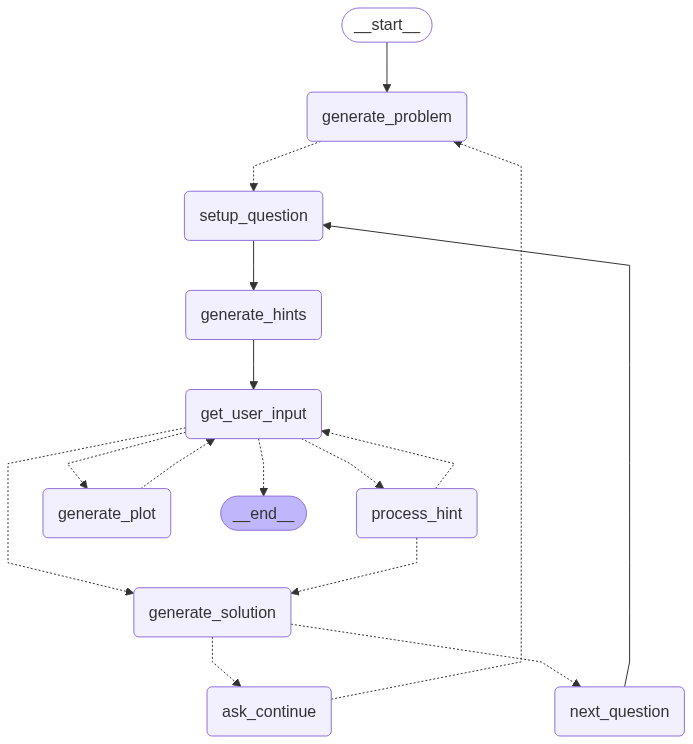

In [31]:
# Visualize the workflow (optional)
langraph_tutor.visualize_workflow()

=== Testing Visualization Agent ===
Sample problem:

Cho tam giác ABC vuông tại A, có AB = 3, AC = 4. Gọi O là tâm đường tròn ngoại tiếp tam giác ABC.
a. Tính độ dài BC và bán kính đường tròn ngoại tiếp.
b. Chứng minh rằng O là trung điểm của BC.
c. Tính diện tích tam giác ABC.


Generating visualization...
\nProblem analysis completed!
Description preview: ```json
{
  "figure_type": "triangle_with_circle",
  "points": {
    "A": [0, 0],
    "B": [3, 0],
    "C": [0, 4],
    "O": [1.5, 2]
  },
  "lines": [
    ["A", "B"],
    ["B", "C"],
    ["C", "A"]
 ...
\nProblem analysis completed!
Description preview: ```json
{
  "figure_type": "triangle_with_circle",
  "points": {
    "A": [0, 0],
    "B": [3, 0],
    "C": [0, 4],
    "O": [1.5, 2]
  },
  "lines": [
    ["A", "B"],
    ["B", "C"],
    ["C", "A"]
 ...


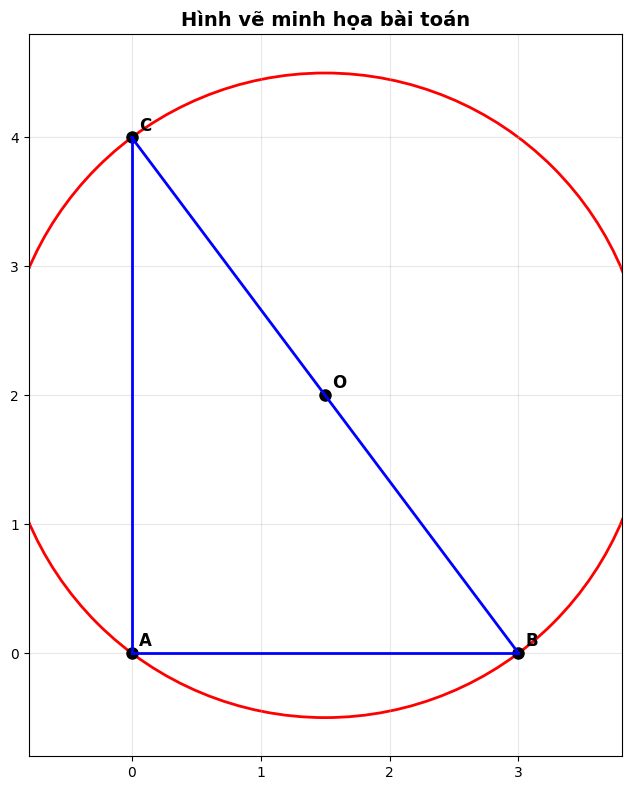

\nVisualization created successfully!


In [13]:
# Test the visualization agent independently
test_problem = """
Cho tam giác ABC vuông tại A, có AB = 3, AC = 4. Gọi O là tâm đường tròn ngoại tiếp tam giác ABC.
a. Tính độ dài BC và bán kính đường tròn ngoại tiếp.
b. Chứng minh rằng O là trung điểm của BC.
c. Tính diện tích tam giác ABC.
"""

print("=== Testing Visualization Agent ===")
print("Sample problem:")
print(test_problem)
print("\nGenerating visualization...")

# Test the visualization
viz_agent = GeometryVisualizationAgent(llm)
description = viz_agent.analyze_geometry_problem(test_problem)
if description:
    print("\\nProblem analysis completed!")
    print(
        "Description preview:",
        description[:200] + "..." if len(description) > 200 else description,
    )

    # Create the plot
    success = viz_agent.create_plot(description, test_problem)
    if success:
        print("\\nVisualization created successfully!")
    else:
        print("\\nFallback visualization created.")
else:
    print("\\nError in problem analysis.")

Chào mừng bạn đến với gia sư hình học AI! Hãy bắt đầu với bài toán đầu tiên.
Đang tạo một bài toán mới...

--------------------------------------------------
Đây là đề bài:
**Bài toán:**

Cho đường tròn (O) và điểm A nằm ngoài đường tròn. Từ A kẻ hai tiếp tuyến AB, AC đến đường tròn (O) (B, C là các tiếp điểm). Gọi H là giao điểm của AO và BC.

a. Chứng minh tứ giác ABOC nội tiếp đường tròn.

b. Gọi D là điểm đối xứng của B qua O. Đường thẳng CD cắt AO tại E. Chứng minh: AC<sup>2</sup> = AE.AH.

c. Gọi M là giao điểm của BD và AC. Chứng minh ba điểm B, E, M thẳng hàng.
--------------------------------------------------


--------------------------------------------------
Câu hỏi hiện tại: 1
a. Chứng minh tứ giác ABOC nội tiếp đường tròn.
--------------------------------------------------

Đang tạo gợi ý...

--------------------------------------------------
Đây là đề bài:
**Bài toán:**

Cho đường tròn (O) và điểm A nằm ngoài đường tròn. Từ A kẻ hai tiếp tuyến AB, AC đến đường tròn (O) 

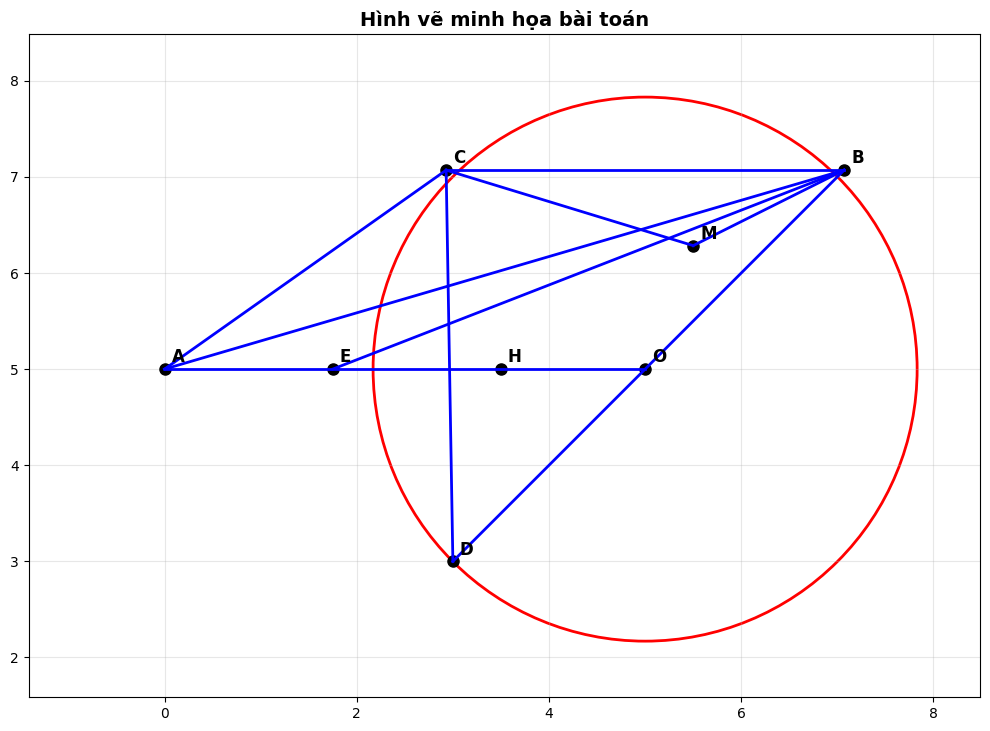

Hình vẽ đã được tạo thành công!

Gợi ý 1: 1.  **Gợi ý 1:** Sử dụng một trong các dấu hiệu nhận biết tứ giác nội tiếp.


Gợi ý 1: 1.  **Gợi ý 1:** Sử dụng một trong các dấu hiệu nhận biết tứ giác nội tiếp.


Gợi ý 2: 2.  **Gợi ý 2:** Chứng minh tổng hai góc đối trong tứ giác ABOC bằng 180 độ.


Gợi ý 2: 2.  **Gợi ý 2:** Chứng minh tổng hai góc đối trong tứ giác ABOC bằng 180 độ.


Gợi ý 3: 3.  **Gợi ý 3:** Chứng minh góc ABO + góc ACO = 180 độ, sử dụng tính chất tiếp tuyến.


Gợi ý 3: 3.  **Gợi ý 3:** Chứng minh góc ABO + góc ACO = 180 độ, sử dụng tính chất tiếp tuyến.


Đang tạo lời giải chi tiết...

Đang tạo lời giải chi tiết...

Lời giải cho câu hỏi này:
**Lời giải câu a:**

**Phát biểu cần chứng minh:** Tứ giác ABOC nội tiếp đường tròn.

**Phân tích:** Để chứng minh tứ giác ABOC nội tiếp, ta cần chứng minh một trong các điều kiện sau:

1. Tổng hai góc đối diện bằng 180 độ.
2. Góc ngoài tại một đỉnh bằng góc trong tại đỉnh đối diện.
3. Hai đỉnh kề nhau cùng nhìn cạnh đối diện dưới mộ

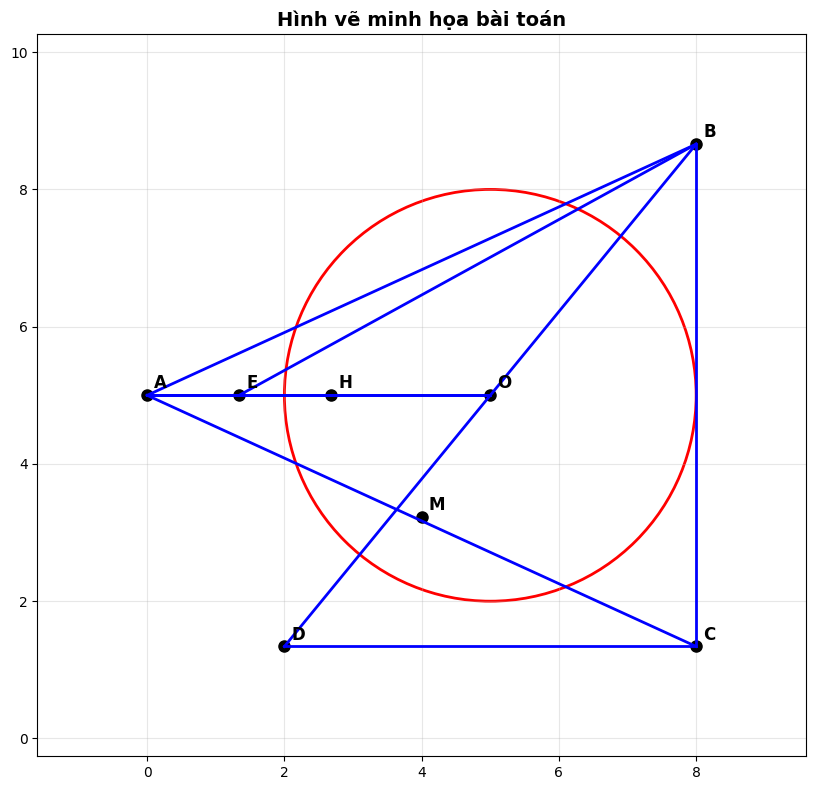

Hình vẽ đã được tạo thành công!
Đã xảy ra lỗi: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
Đã xảy ra lỗi: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


In [14]:
# Start the tutoring session
# Uncomment the line below to start the interactive session
langraph_tutor.start_session()

# Math Tutor with LangGraph
This notebook implements an AI geometry tutor using LangGraph for workflow orchestration.